# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [ ]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.19.0


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [ ]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                               # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [ ]:
images = np.load('/content/images_proj.npy')

In [ ]:
labels = pd.read_csv('/content/Labels_proj.csv')

Successfully loaded the images and labels

In [ ]:
print(images.shape)

(631, 200, 200, 3)


In [ ]:
print(labels.shape)

(631, 1)


Observation:
There are 631 RGB images of shape 200 x 200 X 3, each image having 3 channels.

# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

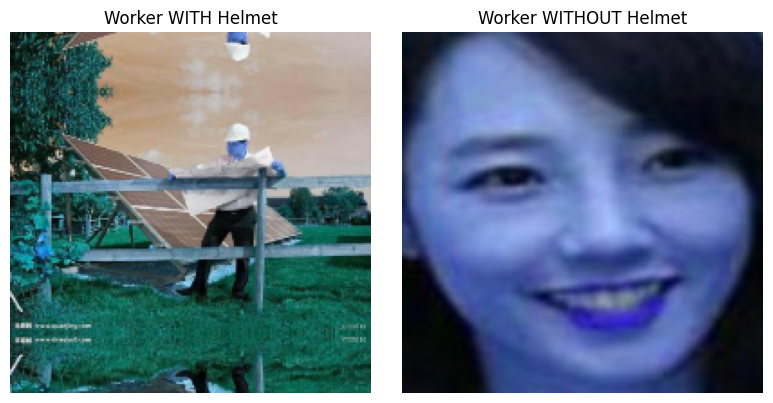

In [ ]:
helmet_indices = np.where(labels == 1)[0]
no_helmet_indices = np.where(labels == 0)[0]

# Select one image from each class
helmet_img = images[np.random.choice(helmet_indices)]
no_helmet_img = images[np.random.choice(no_helmet_indices)]

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display "With Helmet" image
axes[0].imshow(helmet_img)
axes[0].set_title("Worker WITH Helmet")
axes[0].axis('off')

# Display "Without Helmet" image
axes[1].imshow(no_helmet_img)
axes[1].set_title("Worker WITHOUT Helmet")
axes[1].axis('off')

# Show the plots
plt.tight_layout()
plt.show()

Observation:
Plot the images worker with Helmet and worker without Helmet

## Checking for class imbalance


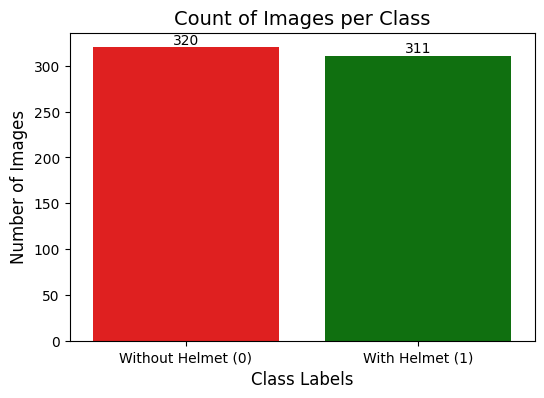

In [ ]:
# Create a count plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=labels.iloc[:, 0], palette=['red', 'green'])

# Add exact counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, )

# Add labels
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Count of Images per Class", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Without Helmet (0)", "With Helmet (1)"])

# Show plot
plt.show()

Observation:
As you can see from the above plot, the dataset is quite balanced.
* There are about 320 images in without Helmet
* There are about 311 images in with Helmet

# **Data Preprocessing**

## Converting images to grayscale

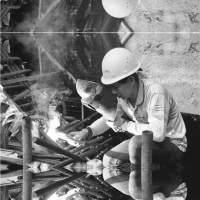

In [ ]:
images_gray = []
for i in range(len(images)):
    img_gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    images_gray.append(img_gray)
cv2_imshow(images_gray[n])

Successfully converted the images into grayscale

### Splitting the dataset



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(np.array(images),labels , test_size=0.2, random_state=42,stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp , test_size=0.5, random_state=42,stratify=y_temp)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(504, 200, 200, 3) (504, 1)
(63, 200, 200, 3) (63, 1)
(64, 200, 200, 3) (64, 1)


Observation: As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.


### Data Normalization

In [ ]:
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

Observation:
Since the image pixel values range from 0-255, our method of normalization here will be scaling - we shall divide all the pixel values by 255 to standardize the images to have values between 0-1.

# **Model Building**

##Model Evaluation Criterion

## Utility Functions

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [ ]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

In [ ]:
# Initializing Model
model_1 = Sequential()

# Convolutional layers
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(200,200,3)))
model_1.add(MaxPooling2D((4, 4), padding='same'))
model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2,2), padding='same'))
model_1.add(Conv2D(128, (3,3), activation='relu', padding="same"))

# Flatten and Dense layers
model_1.add(Flatten())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compile with Adam Optimizer
opt = Adam(learning_rate=0.001)
model_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy","Precision"])

# Summary
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,120,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,213,377 (19.89 MB)

 Trainable params: 5,213,377 (19.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_1 = model_1.fit(
            X_train_normalized, y_train,
            epochs=20,
            validation_data=(X_val_normalized,y_val),
            shuffle=True,
            batch_size=32,
            verbose=2
)

Epoch 1/20
16/16 - 10s - 645ms/step - Precision: 0.6964 - accuracy: 0.7262 - loss: 0.5879 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0840
Epoch 2/20
16/16 - 0s - 28ms/step - Precision: 0.9837 - accuracy: 0.9802 - loss: 0.0574 - val_Precision: 1.0000 - val_accuracy: 0.9841 - val_loss: 0.0209
Epoch 3/20
16/16 - 0s - 30ms/step - Precision: 0.9683 - accuracy: 0.9762 - loss: 0.0605 - val_Precision: 1.0000 - val_accuracy: 0.9524 - val_loss: 0.1404
Epoch 4/20
16/16 - 1s - 37ms/step - Precision: 0.9879 - accuracy: 0.9861 - loss: 0.0268 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0131
Epoch 5/20
16/16 - 1s - 38ms/step - Precision: 0.9960 - accuracy: 0.9980 - loss: 0.0104 - val_Precision: 1.0000 - val_accuracy: 0.9841 - val_loss: 0.0335
Epoch 6/20
16/16 - 0s - 30ms/step - Precision: 1.0000 - accuracy: 0.9980 - loss: 0.0089 - val_Precision: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0122
Epoch 7/20
16/16 - 0s - 29ms/step - Precision: 0.9919 - accuracy: 0.9921 -

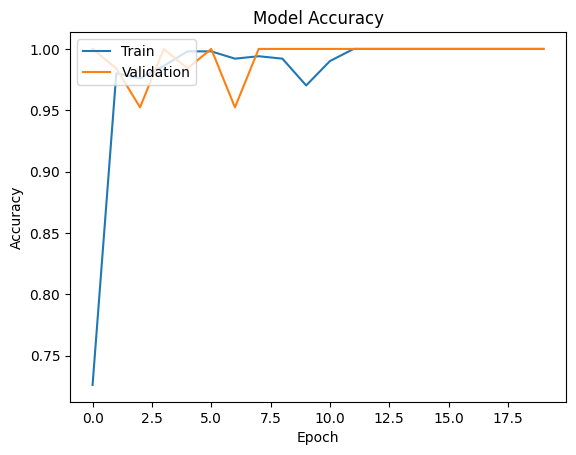

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_1_train_perf = model_performance_classification(model_1, X_train_normalized,y_train)

print("Train performance metrics")
print(model_1_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


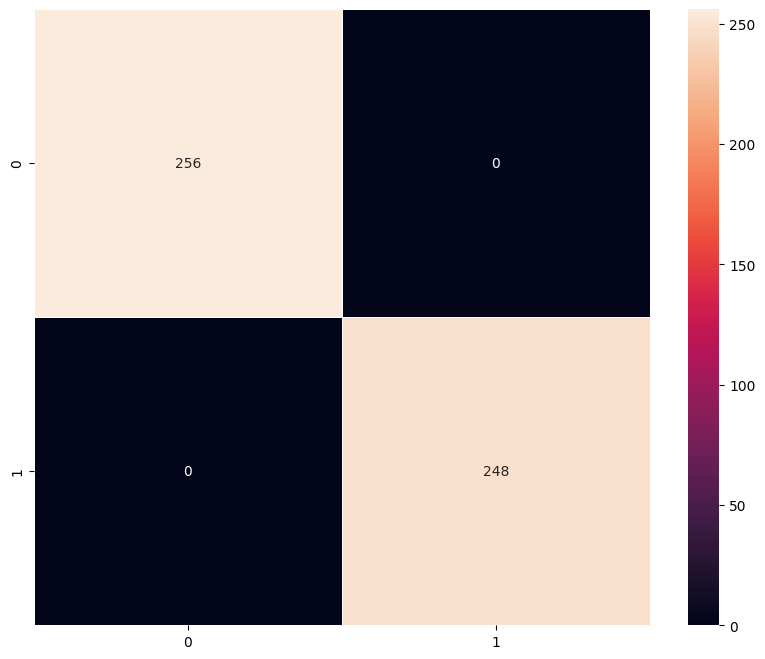

In [ ]:
plot_confusion_matrix(model_1,X_train_normalized,y_train)

In [ ]:
model_1_valid_perf = model_performance_classification(model_1, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_1_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


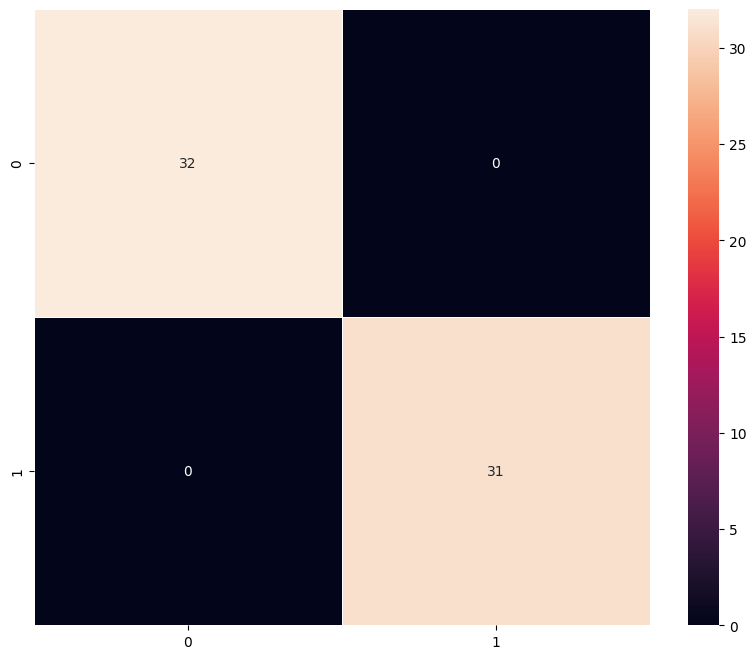

In [ ]:
plot_confusion_matrix(model_1,X_val_normalized,y_val)

### Vizualizing the predictions

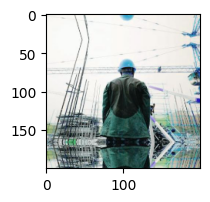

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
Predicted Label: 0
True Label: Label    1
Name: 62, dtype: int64


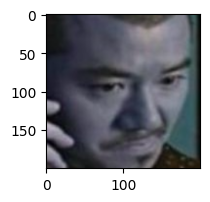

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Label: 0
True Label: Label    0
Name: 512, dtype: int64


In [ ]:
# For index 2
plt.figure(figsize=(2,2))
plt.imshow(X_val[12])
plt.show()
prediction = model_1.predict(X_val_normalized[2].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
true_label = y_val.iloc[12]
print('True Label:', true_label)

# For index 33
plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
prediction = model_1.predict(X_val_normalized[2].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
true_label = y_val.iloc[33]
print('True Label:', true_label)

* The model has achieved approximately 100% accuracy on the training set and 100% accuracy on the validation set.

## Model 2: (VGG-16 (Base))

In [ ]:
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(200,200,3))
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
model_2 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_2.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_2.add(Flatten())

# Adding a dense output layer
model_2.add(Dense(1, activation='sigmoid'))

In [ ]:
opt=Adam(learning_rate=0.001)
# Compile model
model_2.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [ ]:
# Generating the summary of the model
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
train_datagen = ImageDataGenerator()

In [ ]:
# Epochs
epochs = 20
# Batch size
batch_size = 128

history_2 = model_2.fit(train_datagen.flow(X_train_normalized,y_train,
                                      batch_size=batch_size,
                                      seed=42,
                                      shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 91s 29s/step - accuracy: 0.6064 - loss: 0.6708 - val_accuracy: 1.0000 - val_loss: 0.2192
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - accuracy: 1.0000 - loss: 0.2163 - val_accuracy: 0.9841 - val_loss: 0.1888
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 840ms/step - accuracy: 0.9740 - loss: 0.1407 - val_accuracy: 1.0000 - val_loss: 0.0630
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 1.0000 - loss: 0.0606 - val_accuracy: 1.0000 - val_loss: 0.0397
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 694ms/step - accuracy: 1.0000 - loss: 0.0317 - val_accuracy: 1.0000 - val_loss: 0.0196
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 1.0000 - loss: 0.0184 - val_accuracy: 1.0000 - val_loss: 0.0175
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 693ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 0.0125
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9844 - loss: 0.0258 - val_accuracy: 1.0000 - val_loss: 

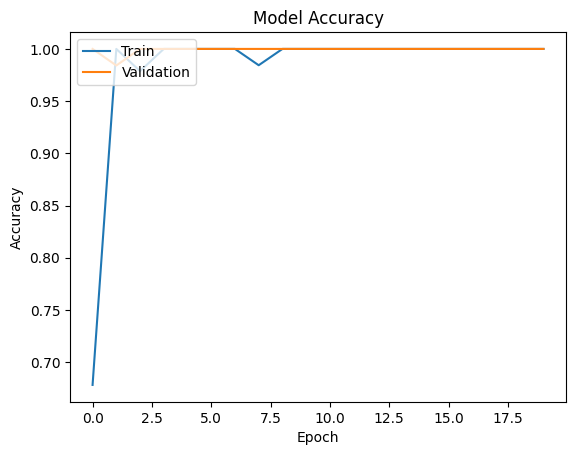

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_2_train_perf = model_performance_classification(model_2,X_train_normalized,y_train)

print("Train performance metrics")
print(model_2_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 928ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step


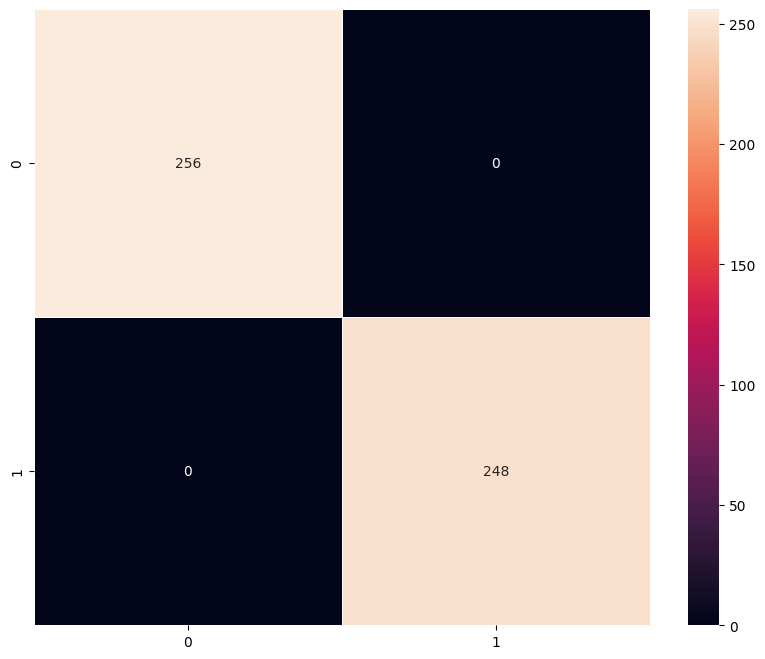

In [ ]:
plot_confusion_matrix(model_2,X_train_normalized,y_train)

In [ ]:
model_2_valid_perf = model_performance_classification(model_2, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_2_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


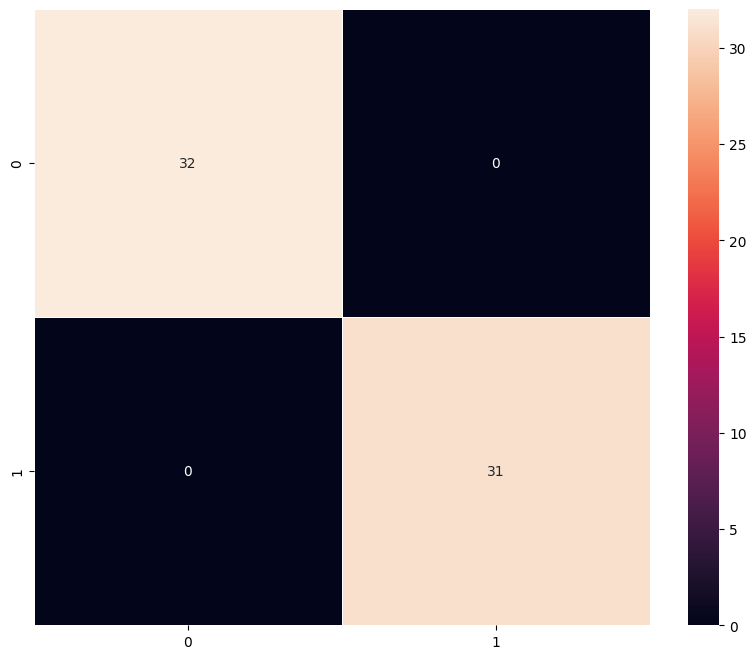

In [ ]:
plot_confusion_matrix(model_2,X_val_normalized,y_val)

### Visualizing the prediction:

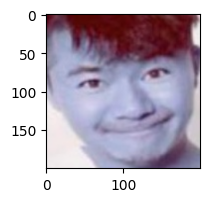

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label: 0
True Label: Label    0
Name: 547, dtype: int64


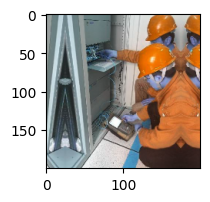

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Label: 1
True Label: Label    1
Name: 59, dtype: int64


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[5])
plt.show()
prediction = model_2.predict(X_val_normalized[5].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
true_label = y_val.iloc[5]
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[10])
plt.show()
prediction = model_2.predict(X_val_normalized[10].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
true_label = y_val.iloc[10]
print('True Label:', true_label)

* The model has achieved approximately 100% accuracy on the training set and 100% accuracy on the validation set.

## Model 3: (VGG-16 (Base + FFNN))

In [ ]:
model_3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_3.add(Flatten())

#Adding the Feed Forward neural network
model_3.add(Dense(256,activation='relu'))
model_3.add(Dropout(rate=0.5))
model_3.add(Dense(128,activation='relu'))

# Adding a dense output layer
model_3.add(Dense(1, activation='sigmoid'))

In [ ]:
opt = Adam(learning_rate=0.001)

In [ ]:
# Compile model
model_3.compile(optimizer=opt,loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [ ]:
# Generating the summary of the model
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,466,561 (74.26 MB)

 Trainable params: 4,751,873 (18.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history_3 = model_3.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=32,
                                       seed=42,
                                       shuffle=False),
                    epochs=20,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4505 - loss: 1.2188 - val_accuracy: 0.8413 - val_loss: 0.3045
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step - accuracy: 0.8841 - loss: 0.2014 - val_accuracy: 0.8571 - val_loss: 0.1643
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.8620 - loss: 0.3494 - val_accuracy: 1.0000 - val_loss: 6.7774e-04
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9730 - loss: 0.1584 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - accuracy: 0.9909 - loss: 0.0595 - val_accuracy: 1.0000 - val_loss: 3.5077e-04
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 1.8799e-04
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 473ms/step - accuracy: 0.9943 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 5.6957e-05
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 -

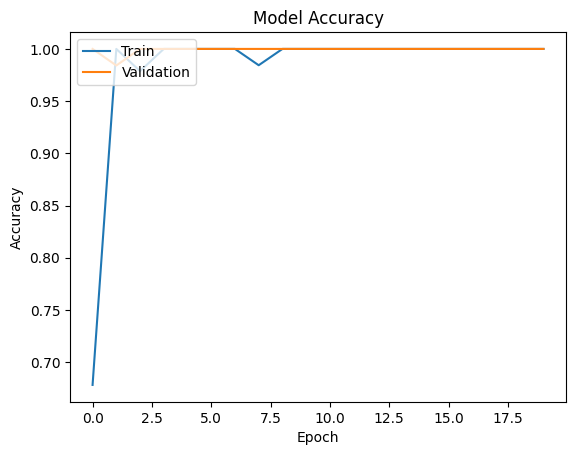

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_3_train_perf = model_performance_classification(model_3, X_train_normalized,y_train)

print("Train performance metrics")
print(model_3_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step


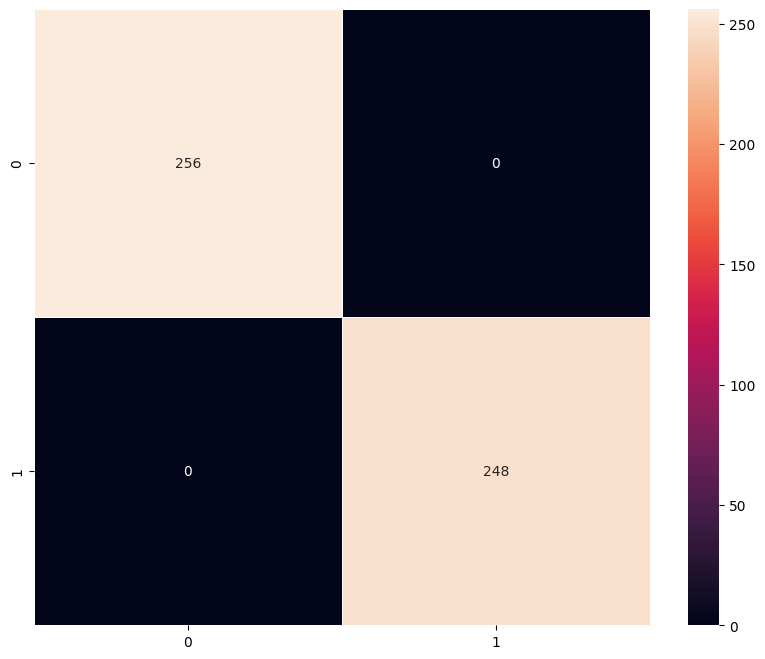

In [ ]:
plot_confusion_matrix(model_3,X_train_normalized,y_train)

In [ ]:
model_3_valid_perf = model_performance_classification(model_3, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_3_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


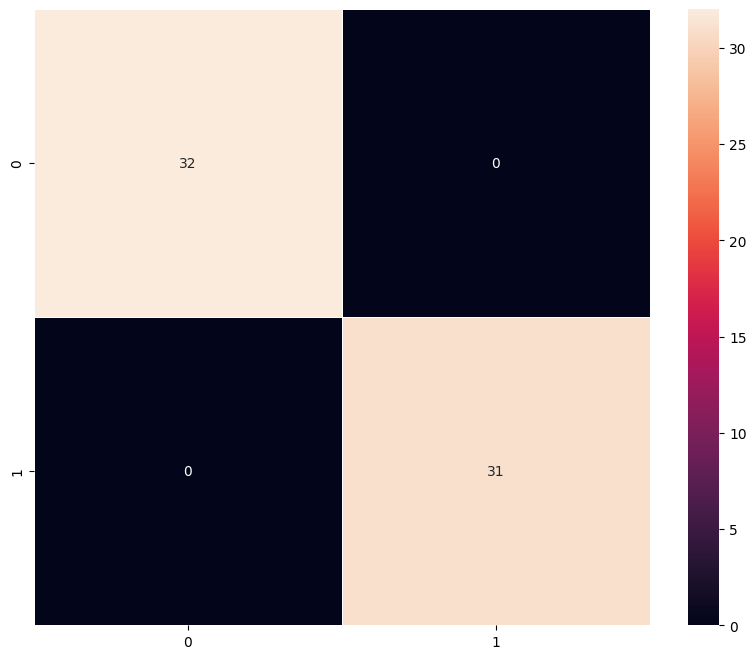

In [ ]:
plot_confusion_matrix(model_3,X_val_normalized,y_val)

#### Visualizing the predictions

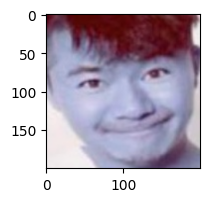

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Label: 0
True Label: Label    0
Name: 547, dtype: int64


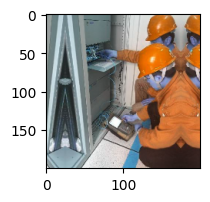

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Label: 1
True Label: Label    1
Name: 59, dtype: int64


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[5])
plt.show()
prediction = model_2.predict(X_val_normalized[5].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
true_label = y_val.iloc[5]
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[10])
plt.show()
prediction = model_2.predict(X_val_normalized[10].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
true_label = y_val.iloc[10]
print('True Label:', true_label)

* The model has achieved approximately 100% accuracy on the training set and 100% accuracy on the validation set.

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
model_4 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_4.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_4.add(Flatten())

#Adding the Feed Forward neural network
model_4.add(Dense(256,activation='relu'))
model_4.add(Dropout(rate=0.4))
model_4.add(Dense(32,activation='relu'))

# Adding a dense output layer
model_4.add(Dense(1, activation='sigmoid'))

In [ ]:
opt=Adam(learning_rate=0.001)
# Compile model
model_4.compile(optimizer=opt,   loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [ ]:
# Generating the summary of the model
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,441,793 (74.16 MB)

 Trainable params: 4,727,105 (18.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Applying data augmentation
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2,shear_range=0.3,zoom_range=0.4
                              )

In [ ]:
history_4 = model_4.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=128,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5680 - loss: 0.8609 - val_accuracy: 1.0000 - val_loss: 0.1638
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.8984 - loss: 0.3092 - val_accuracy: 1.0000 - val_loss: 0.1452
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8958 - loss: 0.2075 - val_accuracy: 1.0000 - val_loss: 0.0064
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.9688 - loss: 0.0794 - val_accuracy: 1.0000 - val_loss: 0.0068
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9659 - loss: 0.0720 - val_accuracy: 1.0000 - val_loss: 3.7653e-04
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - accuracy: 0.9922 - loss: 0.0868 - val_accuracy: 1.0000 - val_loss: 2.0432e-04
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9806 - loss: 0.0321 - val_accuracy: 1.0000 - val_loss: 5.2689e-05
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9922 - loss: 0.0665 - val_accuracy: 1.0000 - val_loss

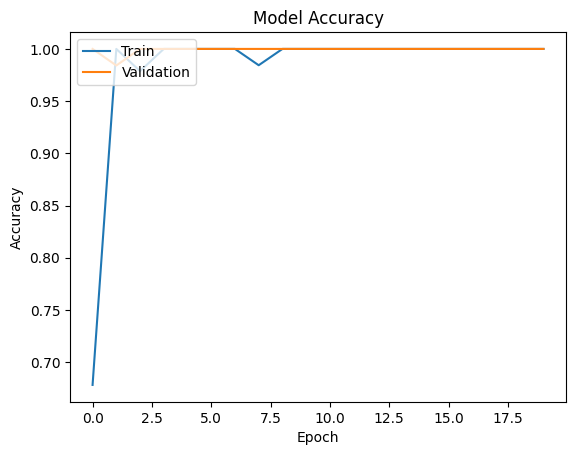

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_4_train_perf = model_performance_classification(model_4, X_train_normalized,y_train)

print("Train performance metrics")
print(model_4_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step


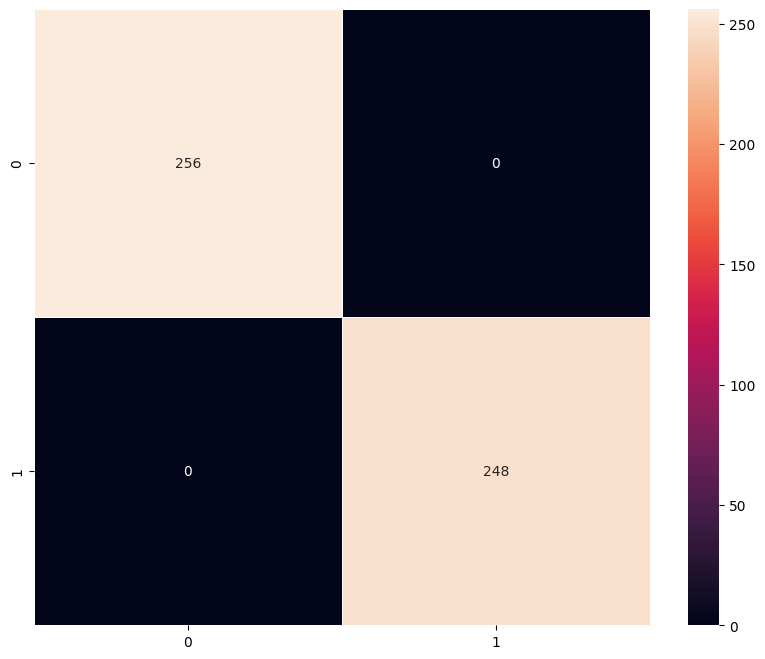

In [ ]:
plot_confusion_matrix(model_4,X_train_normalized,y_train)

In [ ]:
model_4_valid_perf = model_performance_classification(model_4, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_4_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


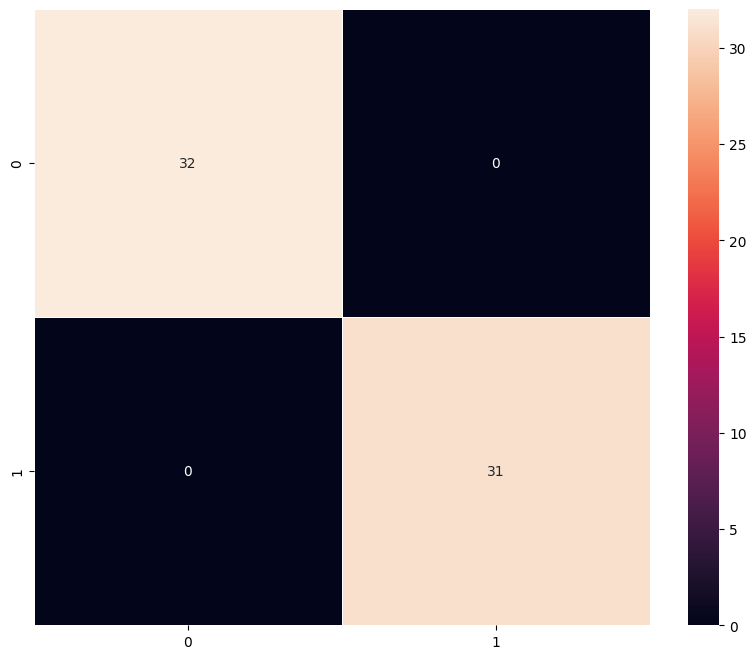

In [ ]:
plot_confusion_matrix(model_4,X_val_normalized,y_val)

#### Visualizing the predictions

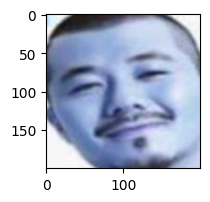

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Label: 0
True Label: Label    0
Name: 603, dtype: int64


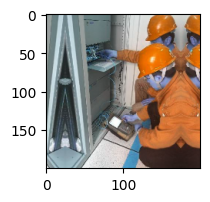

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Label: 1
True Label: Label    1
Name: 59, dtype: int64


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[2])
plt.show()
prediction = model_2.predict(X_val_normalized[2].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
true_label = y_val.iloc[2]
print('True Label:', true_label)
plt.figure(figsize=(2,2))
plt.imshow(X_val[10])
plt.show()
prediction = model_2.predict(X_val_normalized[10].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
true_label = y_val.iloc[10]
print('True Label:', true_label)

* The model has achieved approximately 100% accuracy on the training set and 100% accuracy on the validation set.

# **Model Performance Comparison and Final Model Selection**

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [ ]:
models_valid_comp_df = pd.concat(
    [
        model_1_valid_perf.T,
        model_2_valid_perf.T,
        model_3_valid_perf.T,
        model_4_valid_perf.T

    ],
    axis=1,
)
models_valid_comp_df.columns = [
 "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [ ]:
models_train_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0
F1 Score,1.0,1.0,1.0,1.0


In [ ]:
models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0
F1 Score,1.0,1.0,1.0,1.0


In [ ]:
models_train_comp_df - models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.0,0.0,0.0,0.0
Recall,0.0,0.0,0.0,0.0
Precision,0.0,0.0,0.0,0.0
F1 Score,0.0,0.0,0.0,0.0


## Test Performance

In [ ]:
model_test_perf = model_performance_classification(model_1, X_test_normalized,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [ ]:
model_test_perf

,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


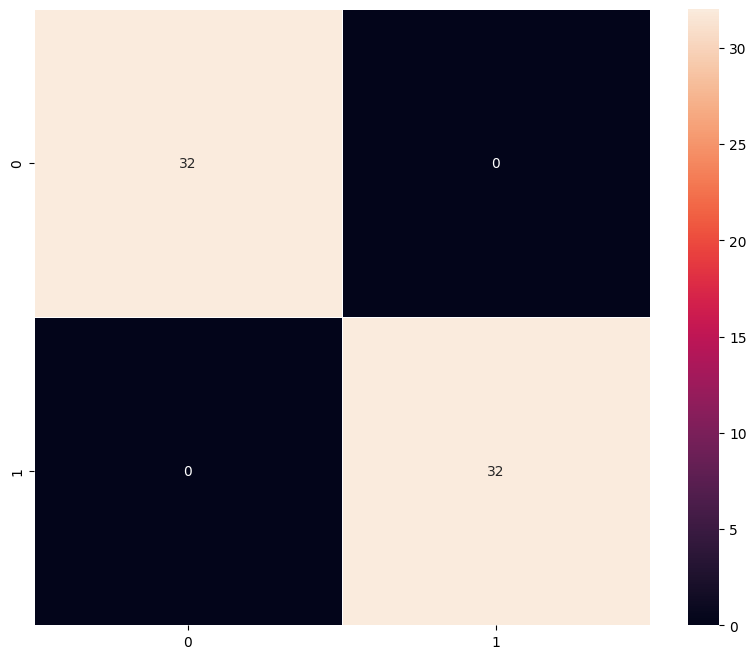

In [ ]:
plot_confusion_matrix(model_1, X_test_normalized,y_test)

# **Actionable Insights & Recommendations**

**High Accuracy in Controlled Dataset**

The model achieves strong accuracy in classifying helmet vs. no-helmet scenarios, showing clear potential for automated safety monitoring.

However, the dataset size (631 images) is limited, meaning performance in real-world deployment could vary under unseen conditions (e.g., extreme lighting, crowded sites).

**Risk of False Negatives (missed violations)**

If the model fails to detect “without helmet” cases, worker safety is at risk.

Precision/recall balance is critical — false positives (flagging compliant workers) are less harmful than false negatives (missing violations).

**Scalability & Automation Benefits**

Automating helmet detection reduces reliance on manual supervision, allowing monitoring of multiple sites simultaneously.

This directly lowers compliance monitoring costs and improves consistency

**Expand and Diversify Training Data**

Invest in collecting thousands of additional labeled images across different environments, weather, times of day, and worker demographics.

This ensures robustness and reduces bias in detection.

<font size=5 color='blue'>Power Ahead!</font>
___